### About this notebook
#### Hi everyone! I'm a beginner in NLP and happy to win a medal in this comp. This notebook is one part of my single model notebooks before blending with others' results. I think this single model performs well(public lb 0.9448). The main highlight is the downstream structure of the model, which is more suitable for novices like me for reference.

The entire notebook is based on the [baseline](https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta) provided by [@xhlulu](https://www.kaggle.com/xhlulu/).

For the model, I used the [MLM finetuned XLM-R large](https://www.kaggle.com/riblidezso/jigsaw-mlm-finetuned-xlm-r-large) provided by [@riblidezso](https://www.kaggle.com/riblidezso).

And it trains on the different translated data in [translated data(Google API)](https://www.kaggle.com/miklgr500/jigsaw-train-multilingual-coments-google-api) provided by [@miklgr500](https://www.kaggle.com/miklgr500).

### References
* Original Author:  [@xhlulu](https://www.kaggle.com/xhlulu/)

* Original notebook:  [Link](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)

* some functions for cleaning data: [link](https://www.kaggle.com/shonenkov/tpu-inference-super-fast-xlmroberta) by [@shonenkov](https://www.kaggle.com/shonenkov)

* model:  [Link](https://www.kaggle.com/riblidezso/jigsaw-mlm-finetuned-xlm-r-large) by [@riblidezso](https://www.kaggle.com/riblidezso)

* dataset:  [Link](https://www.kaggle.com/miklgr500/jigsaw-train-multilingual-coments-google-api) by [@miklgr500](https://www.kaggle.com/miklgr500)

Many Thanks for their nice work!

## Import What We Need

In [ ]:
import os

import re
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
import transformers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets

from transformers import TFAutoModel, AutoTokenizer, AutoConfig
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 40
seed_everything(SEED)

## Helper Functions

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=True, 
        return_token_type_ids=True,
        pad_to_max_length=True,
        max_length=maxlen
    )
    return np.array(enc_di['input_ids'],dtype=np.int32),np.array(enc_di['attention_mask'],dtype=np.int32),np.array(enc_di['token_type_ids'],dtype=np.int32)

In [ ]:
LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

def get_sentences(text, lang='en'):
    return sent_tokenize(text, LANGS.get(lang, 'english'))

def exclude_duplicate_sentences(text, lang='en'):
    sentences = []
    for sentence in get_sentences(text, lang):
        sentence = sentence.strip()
        if sentence not in sentences:
            sentences.append(sentence)
    return ' '.join(sentences)

def clean_text(text, lang='en'):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = exclude_duplicate_sentences(text, lang)
    return text.strip()

## Build model

#### I tried to combine various model structures in the downstream of xlm-roberta, and found that **stacking the last three layers and combining with CNN** brings the most outstanding effect (after parameter selection)

In [ ]:
#last 3 layers
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

#     sequence_output = transformer((input_ids,input_mask,segment_ids))[0] #the last layer [batch, seq_len, dim] dim=1024
#     cls_token = sequence_output[:, 0, :]
    _, _, hs = transformer((input_ids,input_mask,segment_ids)) #[batch, seq_len, dim]
    x = tf.stack([hs[-1],hs[-2],hs[-3]])    #[3, batch, seq_len, dim]
    sequence_output = tf.reduce_mean(x, axis = 0)         #[batch, seq_len, dim]
    
    pool_output = []
    kernel_sizes = [3, 4, 5] 
    for kernel_size in kernel_sizes:
        c = Conv1D(filters=64, kernel_size=kernel_size, padding='same',activation='relu',strides=1)(sequence_output) #[batch, seq_len, 2]
        p = GlobalMaxPooling1D()(c) #[batch, 2]
        pool_output.append(p)
    pool_output = concatenate([p for p in pool_output])    #[batch, 8]
    
#     sequence_output = pool_output
#     gp = GlobalMaxPooling1D()(sequence_output) #[batch,dim]
#     gp = Dropout(0.3)(gp)
#     ap = GlobalAveragePooling1D()(sequence_output) #[batch,dim]
#     ap = Dropout(0.3)(ap)
#     stack = concatenate([gp,ap],axis=1) #[batch,2*dim]
#     out = Dropout(0.3)(stack)
    out = pool_output
    out = Dropout(0.3)(out)
    out = Dense(64, activation='relu')(out) #[batch,1]
    out = Dropout(0.3)(out)
    out = Dense(1, activation='sigmoid')(out) #[batch,1]
    
    model = Model(inputs=[input_ids,input_mask,segment_ids], outputs=out)
    model.compile(Adam(lr=0.2e-5), loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])
    
    return model

## TPU Configs

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 210
MODEL = 'jplu/tf-xlm-roberta-large'
PRETRAINED_MODEL = '/kaggle/input/jigsaw-mlm-finetuned-xlm-r-large'

## Create tokenizer

In [ ]:
# Load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

## Data Processing

In [ ]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [ ]:
train3 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-tr-cleaned.csv")
train4 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-it-cleaned.csv")
train5 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-pt-cleaned.csv")
train6 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-ru-cleaned.csv")
train7 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-fr-cleaned.csv")
train8 = pd.read_csv("/kaggle/input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-es-cleaned.csv")

In [ ]:
import seaborn as sns
sns.countplot(valid['lang'])

In [ ]:
sns.countplot(test['lang'])

In [ ]:
train1['toxic'].value_counts()

#### We sample subsets from each datasets.

In [ ]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1').sample(n=60000, random_state=12312),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=60000, random_state=42323),
    ])
train_tr = pd.concat([
    train3[['comment_text', 'toxic']].query('toxic==1'),
    train3[['comment_text', 'toxic']].query('toxic==0').sample(n=50000, random_state=23412),
])
train_it = pd.concat([
    train4[['comment_text', 'toxic']].query('toxic==1'),
    train4[['comment_text', 'toxic']].query('toxic==0').sample(n=50000, random_state=23412),
])
train_pt = pd.concat([
    train5[['comment_text', 'toxic']].query('toxic==1'),
    train5[['comment_text', 'toxic']].query('toxic==0').sample(n=50000, random_state=75293),
])
train_ru = pd.concat([
    train6[['comment_text', 'toxic']].query('toxic==1'),
    train6[['comment_text', 'toxic']].query('toxic==0').sample(n=50000, random_state=17479),
])
train_fr = pd.concat([
    train7[['comment_text', 'toxic']].query('toxic==1'),
    train7[['comment_text', 'toxic']].query('toxic==0').sample(n=50000, random_state=56321),
])
train_es = pd.concat([
    train8[['comment_text', 'toxic']].query('toxic==1'),
    train8[['comment_text', 'toxic']].query('toxic==0').sample(n=50000, random_state=45874),
])

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x : clean_text(x))
valid['comment_text'] = valid['comment_text'].apply(lambda x : clean_text(x))

train_tr['comment_text'] = train_tr['comment_text'].apply(lambda x : clean_text(x,lang='tr'))
train_pt['comment_text'] = train_pt['comment_text'].apply(lambda x : clean_text(x,lang='pt'))
train_it['comment_text'] = train_it['comment_text'].apply(lambda x : clean_text(x,lang='it'))
train_ru['comment_text'] = train_ru['comment_text'].apply(lambda x : clean_text(x,lang='ru'))
train_fr['comment_text'] = train_fr['comment_text'].apply(lambda x : clean_text(x,lang='fr'))
train_es['comment_text'] = train_es['comment_text'].apply(lambda x : clean_text(x,lang='es'))
test['content'] = test['content'].apply(lambda x : clean_text(x))


In [ ]:
%%time 

x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_train_tr = regular_encode(train_tr.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_train_pt = regular_encode(train_pt.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_train_it = regular_encode(train_it.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_train_ru = regular_encode(train_ru.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_train_fr = regular_encode(train_fr.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_train_es = regular_encode(train_es.comment_text.values, tokenizer, maxlen=MAX_LEN)

x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_train_tr = train_tr.toxic.values
y_train_pt = train_pt.toxic.values
y_train_it = train_it.toxic.values
y_train_ru = train_ru.toxic.values
y_train_fr = train_fr.toxic.values
y_train_es = train_es.toxic.values

y_valid = valid.toxic.values

## Build datasets objects

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .shuffle(len(train))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)
train_tr_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_tr, y_train_tr))
    .shuffle(len(train_tr))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)
train_it_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_it, y_train_it))
    .shuffle(len(train_it))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)
train_pt_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_pt, y_train_pt))
    .shuffle(len(train_pt))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)
train_ru_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_ru, y_train_ru))
    .shuffle(len(train_ru))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)
train_fr_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_fr, y_train_fr))
    .shuffle(len(train_fr))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)
train_es_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_es, y_train_es))
    .shuffle(len(train_es))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO)
)
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)
# test_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices(x_test)
#     .batch(BATCH_SIZE)
# )

## Load model into the TPU

In [ ]:
%%time
with strategy.scope():
    config = AutoConfig.from_pretrained(PRETRAINED_MODEL)
    config.output_hidden_states = True
    transformer_layer = TFAutoModel.from_pretrained(PRETRAINED_MODEL,config=config)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

## Train Model

#### We train on the different translated training set respectively.

In [ ]:
n_steps = train_tr.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_tr_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS+1,
    shuffle=False,
)

In [ ]:
n_steps = train_it.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_it_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    shuffle=False,
)

In [ ]:
n_steps = train_pt.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_pt_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    shuffle=False,
)

In [ ]:
n_steps = train_ru.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_ru_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    shuffle=False,
)

In [ ]:
n_steps = train_fr.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_fr_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    shuffle=False,
)

In [ ]:
n_steps = train_es.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_es_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    shuffle=False,
)

In [ ]:
#test dataset do not include Engish reviews
# n_steps = train.shape[0] // BATCH_SIZE
# train_history = model.fit(
#     train_dataset,
#     steps_per_epoch=n_steps,
#     validation_data=valid_dataset,
#     epochs=EPOCHS,
#     shuffle=False,
# )

#### We train it for five more epochs on the `validation` set, because the `validation` set seems to be similar to the `test` set.

In [ ]:
%%time
n_steps = valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=5,
    verbose=2,
    shuffle=False,
)

## Submission

In [ ]:
sub['toxic'] = model.predict(x_test, verbose=1)
sub.to_csv('submission.csv', index=False)
sub.head(10)

## What's more
### My final result is blend of awesome kernels [notebooks](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/notebooks) and all my results. The flowing image shows how I change the model structure and use [single language dataset](https://www.kaggle.com/kashnitsky/jigsaw-multilingual-toxic-test-translated) and [multilingual dataset](https://www.kaggle.com/miklgr500/jigsaw-train-multilingual-coments-google-api) to get more single-model results.
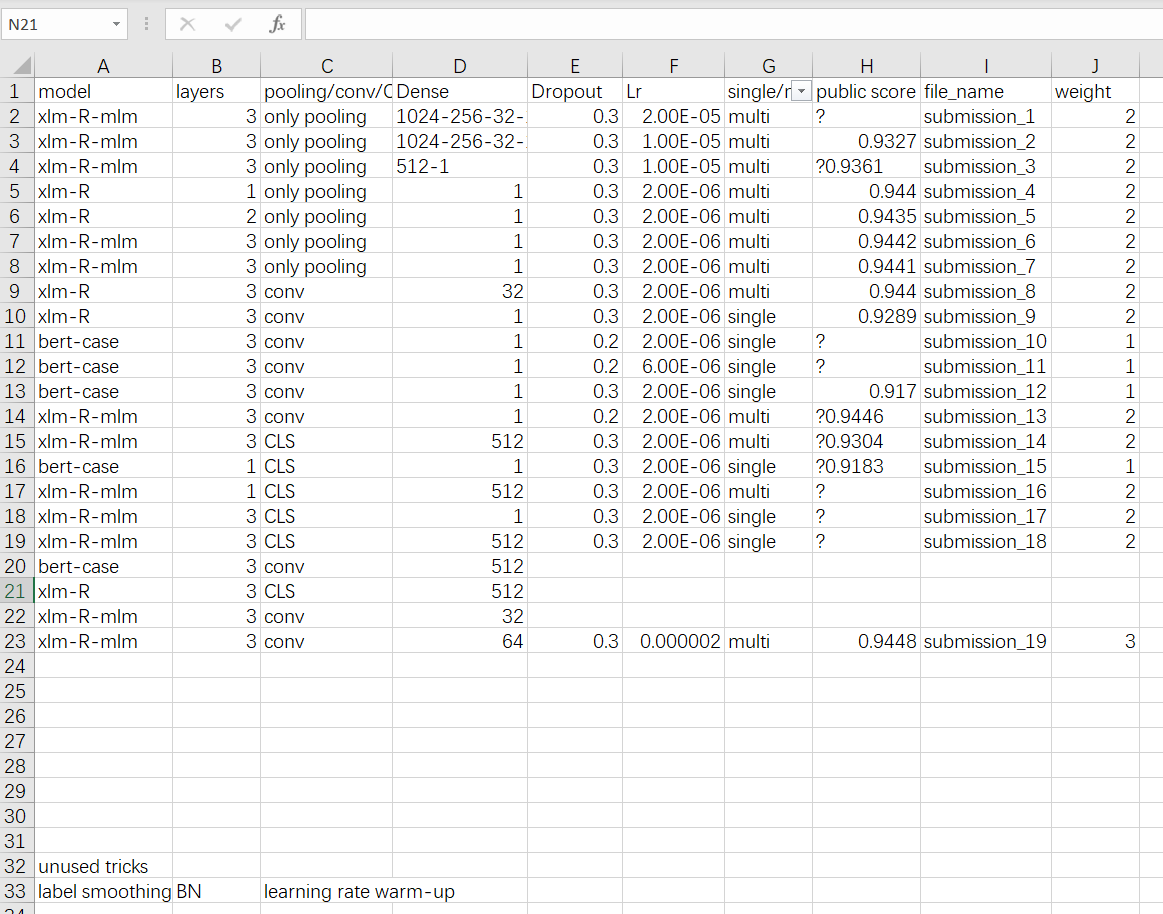